<a href="https://colab.research.google.com/github/BizziBerry/jsbasic-20220606_anelia-education/blob/solutions/se4enov_diet_evaluation_85k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание ИИ-системы для автоматизированной оценки рациона на основе данных о покупках продуктов из чеков.

**Объект исследования:** Данные из чеков супермаркетов, содержащих текстовые записи о товарах.
. <br>
**Предмет исследования:** Детектирование и классификация данных из чеков по соответствующим категориям/разделам.<br>
**Цель работы:** Разработать систему, которая с высокой точностью распознает названия товаров в чеках и классифицирует их по соответствующим категориям, используя методы NLP и машинного обучения, с возможностью последующей интеграции с телеграм-ботом для взаимодействия с пользователями.<br>
**Задачи работы:**<br>
1.Изучить предоставленными данные с наименованием продуктов из чеков и справочником разделов,выбрать метод обработки данных.<br>
2.Выбрать метод анализа данных,метрики для оценки производительности и параметры работы сети.<br>
3.Сформировать,промаркировать и описать набор данных,выделить классы,участвующие в исследовании.<br>
4.Выполнить предобработку данных.<br>
5.Обучить нейронную сеть.<br>
6.Протестировать обученную модель.<br>
7.Создать отчет о проделанной работе.

# Формирование набора данных


Общий объем набора данных составляет 100 тысяч наименований продуктов из чеков в файле xls которые необходимо классифицировать на 14 разделов, согласно предоставленному справочнику с разделами и составом продуков:



# Импорт необходимых библиотек,загрузка набора данных


In [ ]:
from google.colab import files
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')
root = '/drive/My Drive/'

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from IPython.display import clear_output
!pip3 install google-colab
from google.colab.patches import cv2_imshow
clear_output()

In [ ]:
import os
import glob
from imageio import imread
import cv2
from google.colab.patches import cv2_imshow
import imutils
import json

import lightgbm as lgb
import numpy as np
from numpy import int64
import pandas as pd
import seaborn as sns
import scipy
import random
import shutil
import pathlib
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime

from IPython.display import display
from scipy.stats import chi2_contingency, f_oneway
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

import tensorflow as tf
!pip install autokeras
import autokeras as ak
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

import torch
from IPython.display import Image
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw





/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.6 MB/s eta 0:00:00


Загружаем даннные

In [ ]:
# Load the newly uploaded Excel files
df_path = '/content/drive/MyDrive/Colab Notebooks/se4enov/85k.xlsx'

# Read the sheets into dataframes
df = pd.read_excel(df_path)

df_head = df.head(10)

df_head


,Название,Категория
0,Абрикосы 1кг,Абрикосы 9.1.1.1
1,АБРИКОСЫ 500Г,Абрикосы 9.1.1.1
2,Абрикос 6860,Абрикосы 9.1.1.1
3,АБРИКОС 1 КГ МОЛДОВА,Абрикосы 9.1.1.1
4,АБРИКОС 300Г,Абрикосы 9.1.1.1
5,Абрикос Азербайджан кг,Абрикосы 9.1.1.1
6,"Абрикос Армения,кг",Абрикосы 9.1.1.1
7,Абрикос Узбекистан,Абрикосы 9.1.1.1
8,Абрикосы вес (Узбекистан),Абрикосы 9.1.1.1
9,Абрикосы вес Узбекистан,Абрикосы 9.1.1.1


Выведем первые десять строк датафреймов для проверки корректности чтения excel-файлов.

In [ ]:
df.shape

(84497, 2)

In [ ]:
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84497 entries, 0 to 84496
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   84497 non-null  object
 1   Категория  84497 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


None

In [ ]:
# Подсчет пустых значений в каждом столбце cheks_df
count_missing = df.isna().sum()
percent_missing = round(df.isna().sum() * 100 / len(df), 2)
missing_value_df = pd.DataFrame({'count_missing': count_missing, 'percent_missing': percent_missing})
missing_value_df

,count_missing,percent_missing
Название,0,0.0
Категория,0,0.0


In [ ]:
# Подсчет количества уникальных значений в каждом столбце cheks_df
unique_counts = df.nunique()
unique_counts

,0
Название,82425
Категория,1286


#Очистка данных

In [ ]:
# Проверка на дубликаты по столбцу "Название"
duplicates = df[df.duplicated(subset=['Название'], keep=False)]

# Вывод всех дубликатов
print(duplicates)

                                                Название         Категория
8                              Абрикосы вес (Узбекистан)  Абрикосы 9.1.1.1
9                                Абрикосы вес Узбекистан  Абрикосы 9.1.1.1
10                           Абрикосы вес Узбекистан, кг  Абрикосы 9.1.1.1
11             Абрикосы новый урожай вес. 1кг Узбекистан  Абрикосы 9.1.1.1
12                             Абрикосы Шалах Узбекистан  Абрикосы 9.1.1.1
...                                                  ...               ...
84484                                КП/ЯЙЦО ДЕРЕВЕНСКОЕ  Яйцо целое 2.1.1
84485  Яйцо нефас. С-0 10шт (36) Птицефабрика Зеленецкая  Яйцо целое 2.1.1
84486                                       ЯИЦО  1 сорт  Яйцо целое 2.1.1
84487                     UT- Яйцо "Волжское" СО /10шт./  Яйцо целое 2.1.1
84488                        Яйца "Пышминские" С2 10 шт.  Яйцо целое 2.1.1

[4132 rows x 2 columns]


In [ ]:
# Подсчет количества дубликатов по столбцу "Название"
num_duplicates = df['Название'].duplicated().sum()

print(f"Количество дубликатов в столбце 'Название': {num_duplicates}")

Количество дубликатов в столбце 'Название': 2072


In [ ]:
# Display the first few rows of the merged dataframe
duplicates.head(20)

,Название,Категория
8,Абрикосы вес (Узбекистан),Абрикосы 9.1.1.1
9,Абрикосы вес Узбекистан,Абрикосы 9.1.1.1
10,"Абрикосы вес Узбекистан, кг",Абрикосы 9.1.1.1
11,Абрикосы новый урожай вес. 1кг Узбекистан,Абрикосы 9.1.1.1
12,Абрикосы Шалах Узбекистан,Абрикосы 9.1.1.1
14,*516 Абрикосы 1кг,Абрикосы 9.1.1.1
15,516 Абрикосы 1кг,Абрикосы 9.1.1.1
16,580 МЛ АБРИКОСЫ ПОЛ/СИР БАРКО,Абрикосы 9.1.1.1
17,АБРИКОСЫ,Абрикосы 9.1.1.1
18,Абрикосы,Абрикосы 9.1.1.1


In [ ]:
# Удаление дубликатов, где совпадают значения в двух столбцах
df_no_duplicates = df.drop_duplicates(subset=['Название', 'Категория'])

# Выводим информацию о новом DataFrame без дубликатов
print(df_no_duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 82596 entries, 0 to 84496
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   82596 non-null  object
 1   Категория  82596 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB
None


In [ ]:
df_no_duplicates.shape

(82596, 2)

In [ ]:
# Подсчет количества дубликатов по столбцу "Название"
num_duplicates2 = df_no_duplicates['Название'].duplicated().sum()

print(f"Количество дубликатов в столбце 'Название': {num_duplicates2}")

Количество дубликатов в столбце 'Название': 171


In [ ]:
# Удаление дубликатов, где совпадают значения в двух столбцах
df_no_duplicates2 = df_no_duplicates.drop_duplicates(subset=['Название'])

# Выводим информацию о новом DataFrame без дубликатов
print(df_no_duplicates2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 82425 entries, 0 to 84496
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   82425 non-null  object
 1   Категория  82425 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB
None


In [ ]:
# Подсчет количества дубликатов по столбцу "Название"
num_duplicates3 = df_no_duplicates2['Название'].duplicated().sum()

print(f"Количество дубликатов в столбце 'Название': {num_duplicates3}")

Количество дубликатов в столбце 'Название': 0


In [ ]:
df_no_duplicates2.shape

(82425, 2)

In [ ]:
# Сохранить объединенный DataFrame в новый Excel файл
df_no_duplicates2.to_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_no_duplicates2.xlsx', index=False)

Загрузим полный датасет без дубликатов и с заполненными пропущенными значениями

In [ ]:
# Load the newly uploaded Excel files
df_path = '/content/drive/MyDrive/Colab Notebooks/se4enov/df_no_duplicates2.xlsx'

# Read the sheets into dataframes
df = pd.read_excel(df_path)

# Display the first few rows of both dataframes to understand their structure
df.head(20)


,Название,Категория
0,Абрикосы 1кг,Абрикосы 9.1.1.1
1,АБРИКОСЫ 500Г,Абрикосы 9.1.1.1
2,Абрикос 6860,Абрикосы 9.1.1.1
3,АБРИКОС 1 КГ МОЛДОВА,Абрикосы 9.1.1.1
4,АБРИКОС 300Г,Абрикосы 9.1.1.1
5,Абрикос Азербайджан кг,Абрикосы 9.1.1.1
6,"Абрикос Армения,кг",Абрикосы 9.1.1.1
7,Абрикос Узбекистан,Абрикосы 9.1.1.1
8,Абрикосы вес (Узбекистан),Абрикосы 9.1.1.1
9,Абрикосы вес Узбекистан,Абрикосы 9.1.1.1


In [ ]:
df.shape

(82425, 2)

In [ ]:
# Подсчет количества уникальных значений в каждом столбце cheks_df
unique_counts = df.nunique()
unique_counts

,0
Название,82423
Категория,1284


Шаг 1: Удаление лишних пробелов

In [ ]:
def remove_extra_spaces(name):
    # Удаление начальных и конечных пробелов и замена множественных пробелов одним
    return re.sub(r'\s+', ' ', name).strip()


Шаг 2: Приведение к единому регистру

In [ ]:
def to_lowercase(name):
    return name.lower()


Применение всех шагов
Теперь применим все функции по очереди для очистки данных:

In [ ]:
import re

In [ ]:
def clean_product_name(name):
    if not isinstance(name, str):  # Проверка, что ввод является строкой
        return name

    # Применение всех шагов очистки по очереди
    name = remove_extra_spaces(name)
    name = to_lowercase(name)
    # name = remove_special_characters(name)


    return name

In [ ]:
# Применение функции очистки ко всему DataFrame
df_cleaned = df.applymap(clean_product_name)

# Просмотр первых строк после очистки
df_cleaned.head(20)

<ipython-input-35-1bd54d4f5987>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df.applymap(clean_product_name)


,Название,Категория
0,абрикосы 1кг,абрикосы 9.1.1.1
1,абрикосы 500г,абрикосы 9.1.1.1
2,абрикос 6860,абрикосы 9.1.1.1
3,абрикос 1 кг молдова,абрикосы 9.1.1.1
4,абрикос 300г,абрикосы 9.1.1.1
5,абрикос азербайджан кг,абрикосы 9.1.1.1
6,"абрикос армения,кг",абрикосы 9.1.1.1
7,абрикос узбекистан,абрикосы 9.1.1.1
8,абрикосы вес (узбекистан),абрикосы 9.1.1.1
9,абрикосы вес узбекистан,абрикосы 9.1.1.1


In [ ]:
import re
# Обновляем функцию с учетом приведения типов и повторно применяем ее
def extract_weight_and_clean_name_fixed(df_cleaned):
    # Преобразуем все значения в колонке 'Название' в строки, чтобы избежать ошибок
    df_cleaned['Название'] = df_cleaned['Название'].astype(str)

    # Регулярное выражение для поиска числа с единицей измерения
    pattern = r'(\d+(?:[.,]\d+)?\s?(г|кг|мл|мг|л|шт|см|мм|м|литр|килограмм|гр|грамм|ккал|упак|уп|порц))'

    # Функция для применения к каждому элементу колонки 'Название'
    def process_name(name):
        match = re.search(pattern, name)
        if match:
            weight = match.group(0)  # Извлекаем найденное число и единицу измерения
            cleaned_name = re.sub(pattern, '', name).strip()  # Удаляем число и единицу измерения
        else:
            weight = None
            cleaned_name = name
        return pd.Series([weight, cleaned_name])

    # Применяем функцию к каждой строке
    df_cleaned[['Вес и ед. изм.', 'cleaned_name']] = df_cleaned['Название'].apply(process_name)
    return df_cleaned

# Применяем функцию
df_cleaned = extract_weight_and_clean_name_fixed(df_cleaned)

# Выводим первые 10 строк
df_cleaned.head(10)



,Название,Категория,Вес и ед. изм.,cleaned_name
0,абрикосы 1кг,абрикосы 9.1.1.1,1кг,абрикосы
1,абрикосы 500г,абрикосы 9.1.1.1,500г,абрикосы
2,абрикос 6860,абрикосы 9.1.1.1,None,абрикос 6860
3,абрикос 1 кг молдова,абрикосы 9.1.1.1,1 кг,абрикос молдова
4,абрикос 300г,абрикосы 9.1.1.1,300г,абрикос
5,абрикос азербайджан кг,абрикосы 9.1.1.1,None,абрикос азербайджан кг
6,"абрикос армения,кг",абрикосы 9.1.1.1,None,"абрикос армения,кг"
7,абрикос узбекистан,абрикосы 9.1.1.1,None,абрикос узбекистан
8,абрикосы вес (узбекистан),абрикосы 9.1.1.1,None,абрикосы вес (узбекистан)
9,абрикосы вес узбекистан,абрикосы 9.1.1.1,None,абрикосы вес узбекистан


In [ ]:
# Подсчитаем количество значений None (NaN) в колонке 'Вес и ед. изм.'
none_count = df_cleaned['Вес и ед. изм.'].isna().sum()
none_count

35546

In [ ]:
# Функция для добавления пробела между числом и единицей измерения (если его нет)
def add_space_between_weight_and_unit(df_cleaned):
    # Регулярное выражение для поиска чисел, следом за которыми идет единица измерения без пробела
    pattern_no_space = r'(\d+)([а-яА-Яa-zA-Z]+)'

    # Добавляем пробел между числом и единицей измерения
    df_cleaned['Вес и ед. изм.'] = df_cleaned['Вес и ед. изм.'].str.replace(pattern_no_space, r'\1 \2', regex=True)

    return df_cleaned

# Применяем функцию для добавления пробелов
df_cleaned = add_space_between_weight_and_unit(df_cleaned)

# Разделяем столбец "Вес и ед. изм." на два столбца: "Вес" и "ЕИ"
df_cleaned[['Вес', 'ЕИ']] = df_cleaned['Вес и ед. изм.'].str.split(n=1, expand=True)


# Выводим первые 10 строк
df_cleaned.head(20)



,Название,Категория,Вес и ед. изм.,cleaned_name,Вес,ЕИ
0,абрикосы 1кг,абрикосы 9.1.1.1,1 кг,абрикосы,1,кг
1,абрикосы 500г,абрикосы 9.1.1.1,500 г,абрикосы,500,г
2,абрикос 6860,абрикосы 9.1.1.1,None,абрикос 6860,None,None
3,абрикос 1 кг молдова,абрикосы 9.1.1.1,1 кг,абрикос молдова,1,кг
4,абрикос 300г,абрикосы 9.1.1.1,300 г,абрикос,300,г
5,абрикос азербайджан кг,абрикосы 9.1.1.1,None,абрикос азербайджан кг,None,None
6,"абрикос армения,кг",абрикосы 9.1.1.1,None,"абрикос армения,кг",None,None
7,абрикос узбекистан,абрикосы 9.1.1.1,None,абрикос узбекистан,None,None
8,абрикосы вес (узбекистан),абрикосы 9.1.1.1,None,абрикосы вес (узбекистан),None,None
9,абрикосы вес узбекистан,абрикосы 9.1.1.1,None,абрикосы вес узбекистан,None,None


In [ ]:
# Подсчитаем количество значений None (NaN) в столбцах 'Вес' и 'ЕИ'
none_weight_count = df_cleaned['Вес'].isna().sum()
none_unit_count = df_cleaned['ЕИ'].isna().sum()

none_weight_count, none_unit_count

(35546, 35546)

In [ ]:
# Сохранить объединенный DataFrame в новый Excel файл
df_cleaned.to_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_cleaned.xlsx', index=False)

In [ ]:
# Подсчитаем количество уникальных значений для каждого столбца
unique_values_count = df_cleaned.nunique()
unique_values_count

,0
Название,81400
Категория,1262
Вес и ед. изм.,2353
cleaned_name,79248
Вес,1156
ЕИ,13


In [ ]:
# Подсчитаем количество вхождений каждой категории в столбце "Категория"
category_counts = df_cleaned['Категория'].value_counts()
category_counts

,count
Категория,
несъедобное,28584
"пиво светлое, с долей сухих в-в в исходном сусле 11% 11.2.1.1",1987
"напиток на эссенциях («кока-кола», «пепси-кола», «байкал» и др.) 11.1.10.3",1559
хлеб пшеничный формовой из муки в/с 6.1.3.2.1,1325
напиток сокосодержащий,1266
...,...
"соус рыбный, устричный и из др морепродуктов",1
куры 1 кат. 3.1.15.7,1
"кэроб, порошок плодов рожкового дерева",1


In [ ]:
# Подсчитаем, сколько категорий встречаются единожды в столбце "Категория"
single_occurrence_categories = df_cleaned['Категория'].value_counts()[df_cleaned['Категория'].value_counts() == 1].count()
single_occurrence_categories

209

In [ ]:
# Удаляем строки, в которых значения категории встречаются единожды
category_counts = df_cleaned['Категория'].value_counts()
rows_to_remove = df_cleaned['Категория'].isin(category_counts[category_counts == 1].index)

# Фильтруем датафрейм, удаляя строки с единственными категориями
df_cleaned_filtered = df_cleaned[~rows_to_remove]

# Выводим первые несколько строк отфильтрованного датафрейма
df_cleaned_filtered.head(10)

,Название,Категория,Вес и ед. изм.,cleaned_name,Вес,ЕИ
0,абрикосы 1кг,абрикосы 9.1.1.1,1 кг,абрикосы,1,кг
1,абрикосы 500г,абрикосы 9.1.1.1,500 г,абрикосы,500,г
2,абрикос 6860,абрикосы 9.1.1.1,None,абрикос 6860,None,None
3,абрикос 1 кг молдова,абрикосы 9.1.1.1,1 кг,абрикос молдова,1,кг
4,абрикос 300г,абрикосы 9.1.1.1,300 г,абрикос,300,г
5,абрикос азербайджан кг,абрикосы 9.1.1.1,None,абрикос азербайджан кг,None,None
6,"абрикос армения,кг",абрикосы 9.1.1.1,None,"абрикос армения,кг",None,None
7,абрикос узбекистан,абрикосы 9.1.1.1,None,абрикос узбекистан,None,None
8,абрикосы вес (узбекистан),абрикосы 9.1.1.1,None,абрикосы вес (узбекистан),None,None
9,абрикосы вес узбекистан,абрикосы 9.1.1.1,None,абрикосы вес узбекистан,None,None


In [ ]:
df_cleaned_filtered.shape

(82216, 6)

In [ ]:
# Сохранить объединенный DataFrame в новый Excel файл без одинарных значений в столбце Категория
df_cleaned_filtered.to_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_cleaned_filtered.xlsx', index=False)

# Анализ данных

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
# Считывание данных
import pandas as pd
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/se4enov/df_cleaned_filtered.xlsx')

#Пример использования TF-IDF и RandomForest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Подготовка данных
X = df['Название'].astype(str)  # Текстовые данные
y = df['Категория']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Построение модели TF-IDF + RandomForest
model = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Преобразуем текст в TF-IDF признаки
    ('clf', RandomForestClassifier(random_state=42))  # Классификатор Random Forest
])

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Отчет о классификации
print(classification_report(y_test, y_pred))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-457cde343697>", line 9, in <cell line: 9>
    df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_cleaned_filtered.xlsx')
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/excel/_base.py", line 495, in read_excel
    io = ExcelFile(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/excel/_base.py", line 1550, in __init__
    ext = inspect_excel_format(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/excel/_base.py", line 1402, in inspect_excel_format
    with get_handle(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/common.py", line 882, in get_handle
    handle = open(handle, ioargs.mode)
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/se4enov/df_cleaned_filtered.xls

TypeError: object of type 'NoneType' has no len()

#Пример с использованием TD-IDF и MLPClassifier с 5 эпохами:

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Подготовка данных
X = df['Название'].astype(str)
y = df['Категория']



In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели TF-IDF + MLPClassifier
model = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Преобразуем текст в TF-IDF признаки
    ('mlp', MLPClassifier(max_iter=5, random_state=42))  # Многослойный перцептрон с 5 эпохами
])



In [ ]:
# Обучение модели
model.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('mlp', MLPClassifier(max_iter=5, random_state=42))])

In [ ]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Отчет о классификации
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                            precision    recall  f1-score   support

                                                          абрикосы 9.1.1.1       0.75      1.00      0.86         3
                                                                   авокадо       1.00      1.00      1.00         5
                                                             аджика острая       0.90      0.90      0.90        10
                                              азу по 1-432 кулинар 3.5.2.1       1.00      0.33      0.50         6
                                                                     айран       0.00      0.00      0.00         3
                                                            ананас 9.1.5.1       0.00      0.00      0.00         4
                                                          ананасы в сиропе       0.00      0.00      0.00         3
                                         антрекот по 1-404 кулинар 3.5.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Пример с использованием TD-IDF и MLPClassifier с 5 эпохами с гафическими данными

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Подготовка данных (преобразование текста в признаки с использованием TF-IDF)
df_cleaned_filtered = pd.read_excel('path_to_your_file.xlsx')
X = df_cleaned_filtered['cleaned_name'].astype(str)
y = df_cleaned_filtered['Категория']

# Преобразуем текстовые данные в признаки с использованием TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Инициализация MLPClassifier с warm_start=True для обучения по эпохам
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42)

# Массивы для хранения значений precision, recall и f1 по эпохам
train_precision = []
train_recall = []
train_f1 = []
test_precision = []
test_recall = []
test_f1 = []

# Цикл по эпохам (например, 5 эпох)
epochs = 5
for epoch in range(epochs):
    # Обучение модели
    mlp.fit(X_train, y_train)

    # Прогнозы для обучающих и тестовых данных
    y_train_pred = mlp.predict(X_train)
    y_test_pred = mlp.predict(X_test)

    # Подсчет precision, recall и f1-score
    train_precision.append(precision_score(y_train, y_train_pred, average='weighted'))
    train_recall.append(recall_score(y_train, y_train_pred, average='weighted'))
    train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))

    test_precision.append(precision_score(y_test, y_test_pred, average='weighted'))
    test_recall.append(recall_score(y_test, y_test_pred, average='weighted'))
    test_f1.append(f1_score(y_test, y_test_pred, average='weighted'))

    print(f'Epoch {epoch + 1}/{epochs} - Precision: {test_precision[-1]:.4f}, Recall: {test_recall[-1]:.4f}, F1-Score: {test_f1[-1]:.4f}')

# Визуализация метрик precision, recall и f1-score по эпохам
plt.figure(figsize=(12, 8))

# График precision
plt.subplot(3, 1, 1)
plt.plot(range(1, epochs + 1), train_precision, label='Train Precision', marker='o')
plt.plot(range(1, epochs + 1), test_precision, label='Test Precision', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision per Epoch')
plt.legend()

# График recall
plt.subplot(3, 1, 2)
plt.plot(range(1, epochs + 1), train_recall, label='Train Recall', marker='o')
plt.plot(range(1, epochs + 1), test_recall, label='Test Recall', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall per Epoch')
plt.legend()

# График f1-score
plt.subplot(3, 1, 3)
plt.plot(range(1, epochs + 1), train_f1, label='Train F1-Score', marker='o')
plt.plot(range(1, epochs + 1), test_f1, label='Test F1-Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


#Пример с использованием TD-IDF и MLPClassifier с 5 эпохами v2:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Подготовка данных
X = df['Название'].astype(str)
y = df['Категория']



In [ ]:
# Преобразуем текстовые данные в признаки с использованием TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)




In [ ]:
# Обучение модели MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True, random_state=42)

# Массивы для хранения значений точности и потерь по эпохам
train_accuracies = []
test_accuracies = []

# Цикл по эпохам (например, 5 эпох)
epochs = 5
for epoch in range(epochs):
    # Обучение модели
    mlp.fit(X_train, y_train)

    # Прогнозы для обучающих и тестовых данных
    y_train_pred = mlp.predict(X_train)
    y_test_pred = mlp.predict(X_test)

    # Подсчет точности
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Сохранение точности для графиков
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{epochs} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/5 - Train Accuracy: 0.3468, Test Accuracy: 0.3517


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2/5 - Train Accuracy: 0.5375, Test Accuracy: 0.5337


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3/5 - Train Accuracy: 0.6782, Test Accuracy: 0.6694


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 4/5 - Train Accuracy: 0.7532, Test Accuracy: 0.7374


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 5/5 - Train Accuracy: 0.8028, Test Accuracy: 0.7774


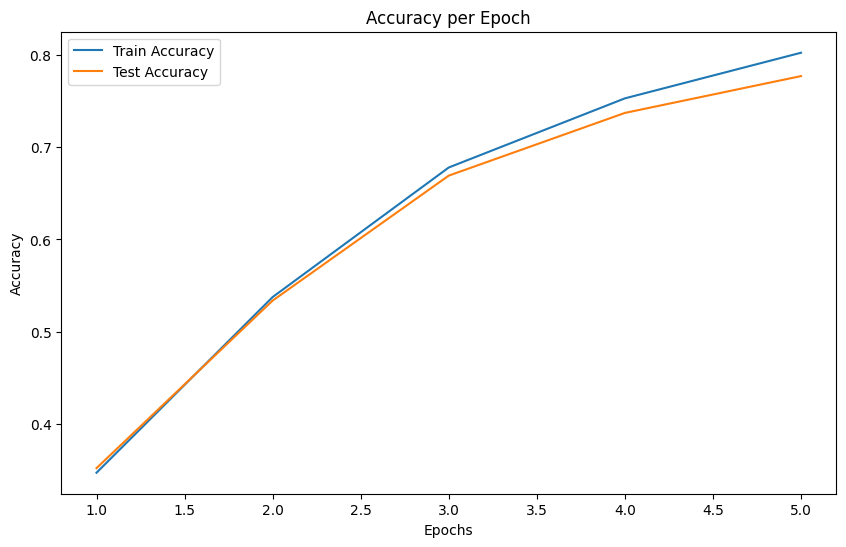

In [ ]:
# Визуализация точности по эпохам
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

#Пример для модели на Keras/TensorFlow, One-Hot Encoding:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# Преобразуем текстовые данные в признаки с использованием TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['Название'].astype(str))

# Преобразуем целевую переменную в числовые категории
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Категория'])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.25, random_state=42)



In [ ]:
# Преобразование целевой переменной в категориальный формат (One-Hot Encoding)
num_classes = len(set(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Построение модели нейронной сети
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  # Softmax для многоклассовой классификации

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели (5 эпох) и сохранение истории
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Визуализация точности и потерь
# График точности
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# подготовка данных (категоризация текстовых данных в числовые)
df['Подкатегория'] = df['Подкатегория'].astype('category').cat.codes
df['Раздел'] = df['Раздел'].astype('category').cat.codes
df['Наименование продукта'] = df['Наименование продукта'].astype('category').cat.codes
df['Количество'] = df['Количество'].astype('category').cat.codes
df['Единицы Измерения'] = df['Единицы Измерения'].astype('category').cat.codes
df.head(10)

,Подкатегория,Раздел,Наименование продукта,Количество,Единицы Измерения
0,1344,186,87226,4827,102
1,616,186,49453,9224,195
2,82,77,20273,3059,57
3,398,57,38501,3681,57
4,573,186,47052,7504,57
5,710,186,86681,7177,57
6,1344,186,7299,8469,185
7,1344,186,8388,10126,185
8,1344,186,20704,3030,-1
9,1344,186,21888,4413,-1


In [ ]:
# Вывод количества уникальных значений в каждом столбце DataFrame
unique_counts = df.nunique()

# Выводим результат
print(unique_counts)

Подкатегория              1347
Раздел                     200
Наименование продукта    97883
Количество               15007
Единицы Измерения          222
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99727 entries, 0 to 99726
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Подкатегория           99727 non-null  int16
 1   Раздел                 99727 non-null  int16
 2   Наименование продукта  99727 non-null  int32
 3   Количество             99727 non-null  int16
 4   Единицы Измерения      99727 non-null  int16
dtypes: int16(4), int32(1)
memory usage: 1.1 MB


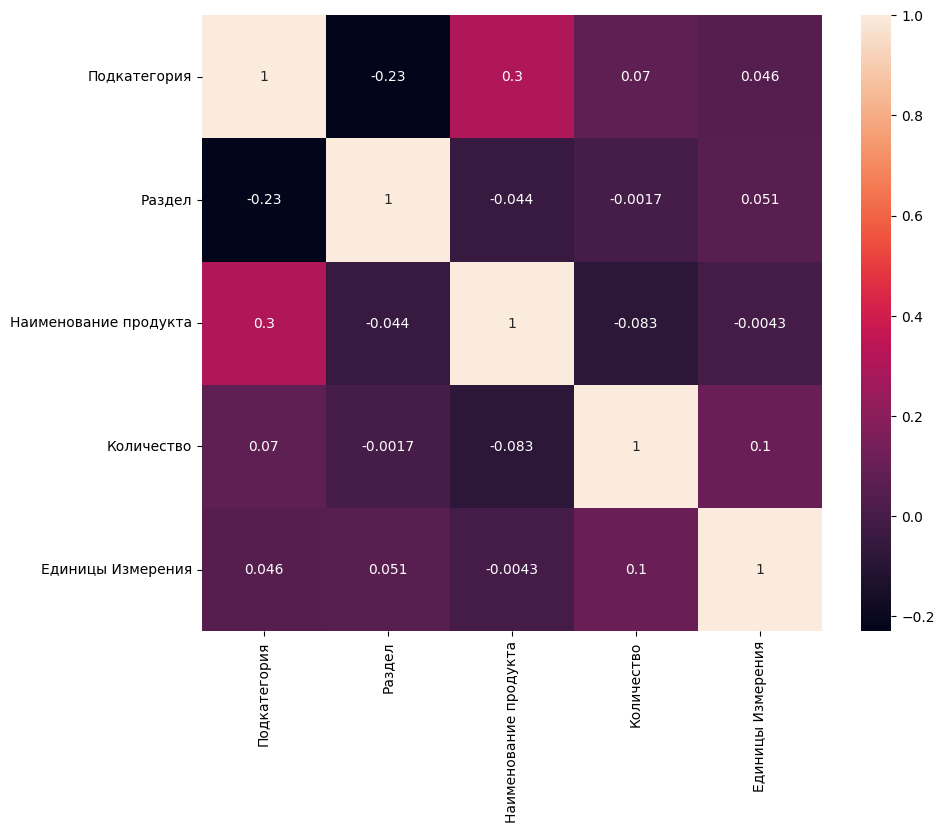

In [ ]:
# построение матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True).round(decimals=4), annot=True)
plt.show()

In [ ]:
# Сохранить объединенный DataFrame в новый Excel файл
df.to_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_final.xlsx', index=False)

# Auto ML

In [ ]:
#AutoML
!pip install autokeras --upgrade
!pip install tensorflow
import autokeras as ak
print(ak.__version__)
import tensorflow as tf
from tensorflow import keras




2.0.0


In [ ]:
# Загрузка данных из CSV файла
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_final.xlsx')

In [ ]:

# Разделяем функцию (X) и целевую переменную (y)
x = df.drop('Подкатегория', axis=1).values  # Удаляем столбец с целевым значением
y = df['Подкатегория'].values  # Установим целевую метку столбец УчетнЦена в качестве целевой переменной

In [ ]:
print(x[:5])

[[  186 87226  4827   102]
 [  186 49453  9224   195]
 [   77 20273  3059    57]
 [   57 38501  3681    57]
 [  186 47052  7504    57]]


In [ ]:
print(y[:5])

[1344  616   82  398  573]


In [ ]:
print(dir(ak))

['AutoModel', 'BayesianOptimization', 'BertBlock', 'Block', 'CUSTOM_OBJECTS', 'CastToFloat32', 'ClassificationHead', 'ConvBlock', 'DenseBlock', 'EfficientNetBlock', 'ExpandLastDim', 'Flatten', 'Greedy', 'Head', 'Hyperband', 'ImageAugmentation', 'ImageBlock', 'ImageClassifier', 'ImageInput', 'ImageRegressor', 'Input', 'Merge', 'Node', 'Normalization', 'RNNBlock', 'RandomSearch', 'RegressionHead', 'ResNetBlock', 'SpatialReduction', 'TemporalReduction', 'TextBlock', 'TextClassifier', 'TextInput', 'TextRegressor', 'XceptionBlock', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'adapters', 'analysers', 'auto_model', 'blocks', 'engine', 'graph', 'hyper_preprocessors', 'image_dataset_from_directory', 'keras_layers', 'keras_nlp', 'nodes', 'pipeline', 'preprocessors', 'tasks', 'text_dataset_from_directory', 'tuners', 'utils']


In [ ]:
from sklearn.model_selection import train_test_split
# Разделение данных на тренировочный и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
# Создание модели AutoML для задачи классификации
model = ak.AutoModel(
    inputs=ak.Input(),  # Задаем вход как универсальные данные
    outputs=ak.ClassificationHead(),  # Определяем выход для задачи классификации
    max_trials=10,  # Максимальное количество попыток для поиска лучшей модели
    overwrite=True  # Перезаписывать старые попытки
)


In [ ]:
# Search for the best model architecture and hyperparameters
model.fit(x_train, y_train, epochs=10)

Trial 10 Complete [00h 10m 45s]
val_loss: 2.6699771881103516

Best val_loss So Far: 2.6699771881103516
Total elapsed time: 00h 36m 48s
Epoch 1/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 79s 33ms/step - accuracy: 0.2204 - loss: 4.5602
Epoch 2/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - accuracy: 0.2711 - loss: 3.5616
Epoch 3/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - accuracy: 0.2860 - loss: 3.3372
Epoch 4/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - accuracy: 0.2979 - loss: 3.1775
Epoch 5/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.3046 - loss: 3.0594
Epoch 6/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.3125 - loss: 2.9711
Epoch 7/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - accuracy: 0.3204 - loss: 2.8928
Epoch 8/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.3229 - loss: 2.8332
Epoch 9/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.3300 - loss: 2.7895
Epoch 10/10
2338/2338 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/ste

In [ ]:
# Save the best model if needed
best_model= model.export_model()


In [ ]:
# Get the summary of the best model
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1273)                │       1,304,825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 1273)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,574,393 (6.01 MB)

 Trainable params: 1,571,833 (6.00 MB)

 Non-trainable params: 2,560 (10.00 KB)

#Random Forest

In [ ]:
# Загрузка данных из CSV файла
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/se4enov/df_final.xlsx')

In [ ]:
# Разделяем функцию (X) и целевую переменную (y)
x = df.drop('Подкатегория', axis=1).values
y = df['Подкатегория'].values  # Установим целевую переменную

In [ ]:
from sklearn.model_selection import train_test_split
# Разделение данных на тренировочный и тестовый наборы
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Создание ансамблевой модели
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

# Оценка модели
accuracy = model.score(x_test, y_test)
print(f"Точность модели: {accuracy}")


#Gradient Boosting

# Заключение